# RANDOM FOREST DEFORESTATION DETECTION - CÀ MAU PROVINCE
## Giám sát biến động rừng bằng Sentinel-1 & Sentinel-2

---

**Project:** Ứng dụng Viễn thám và Học sâu trong Giám sát Biến động Rừng tỉnh Cà Mau  
**Student:** Ninh Hải Đăng (MSSV: 21021411)  
**Year:** 2025 - 2026, Học kỳ I

---

**Pipeline Tổng Quan:**
1. ⚙️ Setup & Load Data (~2-5 phút)
2. 🔧 Feature Extraction (~1-2 phút) - 27 features
3. 📊 Extract Training Data (~30 giây)
4. 🌲 Train Random Forest Model (~3-5 phút)
5. 📈 Model Evaluation (~2-3 phút)
6. 🗺️ Predict Full Raster (~5-10 phút)
7. 📐 Vectorization (~2-5 phút, optional)
8. 📊 Visualization (~1-2 phút)
9. ✅ Summary & Results

**Tổng thời gian:** ~15-30 phút

**Environment:** dangnh (Python 3.11)

---

## 0. IMPORTS & SETUP

In [1]:
# Add src to path
import sys
from pathlib import Path

# Get project root (parent of notebook folder)
notebook_dir = Path.cwd()
if notebook_dir.name == 'notebook':  # Fixed: 'notebook' not 'notebooks'
    project_root = notebook_dir.parent
else:
    project_root = notebook_dir

# Add src directory to path
src_dir = project_root / 'src'
if str(src_dir) not in sys.path:
    sys.path.insert(0, str(src_dir))

print(f"Project root: {project_root}")
print(f"Source directory: {src_dir}")
print(f"[OK] Paths configured successfully")

Project root: d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH
Source directory: d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\src
[OK] Paths configured successfully


In [2]:
# Import all required modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# Import common modules
from common.config import (
    print_config_summary, create_output_directories,
    verify_input_files, FEATURE_NAMES
)
from common.data_loader import DataLoader
from common.feature_extraction import FeatureExtraction
from common.evaluation import ModelEvaluator
from common.visualization import Visualizer

# Import Random Forest modules
from random_forest.train import RandomForestTrainer, TrainingDataExtractor
from random_forest.predict import RasterPredictor

print("[OK] All modules imported successfully!")

[OK] All modules imported successfully!


In [3]:
# Verify files and create output directories
verify_input_files()
create_output_directories()

# Note: print_config_summary() will be called after loading ground truth data

[OK] All required input files exist
[OK] Output directories created successfully


---
## STEP 1-2: LOAD DATA

Load:
- Sentinel-2 Before/After (7 bands each, ~3.8GB per file)
- Sentinel-1 Before/After (2 bands each, ~1.1GB per file)
- Ground Truth CSV (1,300 points)
- Forest Boundary Shapefile

**This may take 2-5 minutes to load ~10GB of data**

In [4]:
%%time
# Create data loader
loader = DataLoader()

# Load all data
print("Loading Sentinel-2 (Optical data)...")
s2_before, s2_after = loader.load_sentinel2()

print("\nLoading Sentinel-1 (SAR data)...")
s1_before, s1_after = loader.load_sentinel1()

print("\nLoading Ground Truth points...")
ground_truth = loader.load_ground_truth()

print("\nLoading Boundary shapefile...")
boundary = loader.load_boundary()

# Get all data
data = {
    's2_before': s2_before,
    's2_after': s2_after,
    's1_before': s1_before,
    's1_after': s1_after,
    'ground_truth': ground_truth,
    'boundary': boundary,
    'metadata': loader.metadata
}

print("\n[SUCCESS] All data loaded!")
loader.print_summary()

2025-11-11 11:35:20 - common.data_loader - INFO - 
2025-11-11 11:35:20 - common.data_loader - INFO - LOADING SENTINEL-2 DATA (OPTICAL)
2025-11-11 11:35:20 - common.data_loader - INFO - ======================================================================
2025-11-11 11:35:21 - common.data_loader - INFO - Loading Sentinel-2 Before (2024-01-30): d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\data\raw\sentinel-2\S2_2024_01_30.tif


Loading Sentinel-2 (Optical data)...


2025-11-11 11:35:26 - common.data_loader - INFO -   [OK] Shape: (7, 10917, 12547)
2025-11-11 11:35:26 - common.data_loader - INFO -   [OK] Bands: 7
2025-11-11 11:35:26 - common.data_loader - INFO -   [OK] CRS: EPSG:32648
2025-11-11 11:35:26 - common.data_loader - INFO -   [OK] NoData: 0.0
2025-11-11 11:35:38 - common.data_loader - INFO - Loading Sentinel-2 After (2025-02-28): d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\data\raw\sentinel-2\S2_2025_02_28.tif
2025-11-11 11:35:44 - common.data_loader - INFO -   [OK] Shape: (7, 10917, 12547)
2025-11-11 11:35:44 - common.data_loader - INFO -   [OK] Bands: 7
2025-11-11 11:35:44 - common.data_loader - INFO -   [OK] CRS: EPSG:32648
2025-11-11 11:35:44 - common.data_loader - INFO -   [OK] NoData: 0.0
2025-11-11 11:35:56 - common.data_loader - INFO - 
[OK] Sentinel-2 data loaded successfully
2025-11-11 11:35:56 - common.data_loader - INFO -   - Expected bands: ['B4', 'B8', 'B11', 'B12', 'NDVI', 'NBR', 'NDMI']
2025-11-11 11:35:56 - common.data_l


Loading Sentinel-1 (SAR data)...


2025-11-11 11:35:58 - common.data_loader - INFO -   [OK] Shape: (2, 10917, 12547)
2025-11-11 11:35:58 - common.data_loader - INFO -   [OK] Bands: 2
2025-11-11 11:35:58 - common.data_loader - INFO -   [OK] CRS: EPSG:32648
2025-11-11 11:35:58 - common.data_loader - INFO -   [OK] NoData: 0.0
2025-11-11 11:36:00 - common.data_loader - INFO - Loading Sentinel-1 After (2025-02-22): d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\data\raw\sentinel-1\S1_2025_02_22_matched_S2_2025_02_28.tif
2025-11-11 11:36:01 - common.data_loader - INFO -   [OK] Shape: (2, 10917, 12547)
2025-11-11 11:36:01 - common.data_loader - INFO -   [OK] Bands: 2
2025-11-11 11:36:01 - common.data_loader - INFO -   [OK] CRS: EPSG:32648
2025-11-11 11:36:01 - common.data_loader - INFO -   [OK] NoData: 0.0
2025-11-11 11:36:04 - common.data_loader - INFO - 
[OK] Sentinel-1 data loaded successfully
2025-11-11 11:36:04 - common.data_loader - INFO -   - Expected bands: ['VV', 'VH']
2025-11-11 11:36:04 - common.data_loader - INFO - 


Loading Ground Truth points...

Loading Boundary shapefile...


2025-11-11 11:36:04 - common.data_loader - INFO - 
[OK] Boundary loaded successfully
2025-11-11 11:36:04 - common.data_loader - INFO -   - CRS: EPSG:32648
2025-11-11 11:36:04 - common.data_loader - INFO -   - Features: 666
2025-11-11 11:36:04 - common.data_loader - INFO -   - Bounds: [ 465449.59497322  946649.76444972  590929.44661728 1055826.02611518]
2025-11-11 11:36:04 - common.data_loader - INFO - 
2025-11-11 11:36:04 - common.data_loader - INFO - DATA SUMMARY
2025-11-11 11:36:04 - common.data_loader - INFO - ======================================================================
2025-11-11 11:36:04 - common.data_loader - INFO - 
Sentinel-2:
2025-11-11 11:36:04 - common.data_loader - INFO -   - Shape: (7, 10917, 12547)
2025-11-11 11:36:04 - common.data_loader - INFO -   - Bands: ['B4', 'B8', 'B11', 'B12', 'NDVI', 'NBR', 'NDMI']
2025-11-11 11:36:04 - common.data_loader - INFO -   - Resolution: 10m
2025-11-11 11:36:04 - common.data_loader - INFO - 
Sentinel-1:
2025-11-11 11:36:04 - co


[SUCCESS] All data loaded!
CPU times: total: 43.9 s
Wall time: 43.9 s


In [5]:
# Print configuration summary with actual ground truth stats
print_config_summary(ground_truth_df=ground_truth)


RANDOM FOREST DEFORESTATION DETECTION - CONFIGURATION

DATA CONFIGURATION:
  - Total Features: 27
  - Sentinel-2 Bands: 7 bands
  - Sentinel-1 Bands: 2 bands
  - Ground Truth Points: 10463
  - Class 0 (No Deforestation): 5368
  - Class 1 (Deforestation): 5095

RANDOM FOREST CONFIGURATION:
  - Number of Trees: 100
  - Max Features: sqrt
  - Class Weight: balanced
  - OOB Score: True

DATA SPLIT:
  - Train: 70%
  - Validation: 15%
  - Test: 15%

CROSS VALIDATION:
  - K-Folds: 5

OUTPUT DIRECTORIES:
  - Rasters: d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\results\rasters
  - Models: d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\results\models
  - Data: d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\results\data
  - Plots: d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\results\plots



---
## STEP 3: FEATURE EXTRACTION

Create 27 features:
- **Sentinel-2:** 7 before + 7 after + 7 delta = 21 features
- **Sentinel-1:** 2 before + 2 after + 2 delta = 6 features

**Expected time: 1-2 minutes**

In [6]:
%%time
# Create feature extractor
extractor = FeatureExtraction()

# Extract features
feature_stack, valid_mask = extractor.extract_features(
    data['s2_before'],
    data['s2_after'],
    data['s1_before'],
    data['s1_after']
)

# Get summary
summary = extractor.get_feature_summary()
print(f"\n[SUCCESS] Feature extraction completed!")
print(f"  - Feature stack shape: {feature_stack.shape}")
print(f"  - Valid pixels: {summary['valid_pixels']:,} ({summary['valid_percentage']:.2f}%)")

2025-11-11 11:36:04 - common.feature_extraction - INFO - 
2025-11-11 11:36:04 - common.feature_extraction - INFO - STEP 3: FEATURE EXTRACTION
2025-11-11 11:36:04 - common.feature_extraction - INFO - ======================================================================
2025-11-11 11:36:04 - common.feature_extraction - INFO - 
Input dimensions: 10917 x 12547
2025-11-11 11:36:04 - common.feature_extraction - INFO - 
Creating valid pixel mask...
2025-11-11 11:36:11 - common.feature_extraction - INFO -   ✓ Valid pixels: 15,569,516 / 136,975,599 (11.37%)
2025-11-11 11:36:11 - common.feature_extraction - INFO - 
Engineering Sentinel-2 features...
2025-11-11 11:36:11 - common.feature_extraction - INFO -   - Adding S2 Before bands (7 features)
2025-11-11 11:36:11 - common.feature_extraction - INFO -   - Adding S2 After bands (7 features)
2025-11-11 11:36:11 - common.feature_extraction - INFO -   - Calculating S2 Delta (7 features)
2025-11-11 11:36:13 - common.feature_extraction - INFO -   ✓ To


[SUCCESS] Feature extraction completed!
  - Feature stack shape: (27, 10917, 12547)
  - Valid pixels: 15,569,516 (11.37%)
CPU times: total: 32 s
Wall time: 32 s


In [7]:
# Visualize feature names
print("\nFeature Names (27 total):")
for i, name in enumerate(FEATURE_NAMES, 1):
    print(f"  {i:2d}. {name}")


Feature Names (27 total):
   1. S2_before_B4
   2. S2_before_B8
   3. S2_before_B11
   4. S2_before_B12
   5. S2_before_NDVI
   6. S2_before_NBR
   7. S2_before_NDMI
   8. S2_after_B4
   9. S2_after_B8
  10. S2_after_B11
  11. S2_after_B12
  12. S2_after_NDVI
  13. S2_after_NBR
  14. S2_after_NDMI
  15. S2_delta_B4
  16. S2_delta_B8
  17. S2_delta_B11
  18. S2_delta_B12
  19. S2_delta_NDVI
  20. S2_delta_NBR
  21. S2_delta_NDMI
  22. S1_before_VV
  23. S1_before_VH
  24. S1_after_VV
  25. S1_after_VH
  26. S1_delta_VV
  27. S1_delta_VH


---
## STEP 4: EXTRACT TRAINING DATA

- Extract feature values at 1,300 ground truth points
- Split into Train (70%) / Validation (15%) / Test (15%)
- Stratified sampling to maintain class distribution

**Expected time: < 30 seconds**

In [8]:
%%time
# Create extractor
extractor = TrainingDataExtractor()

# Extract features at ground truth locations
training_df = extractor.extract_pixel_values(
    feature_stack,
    data['ground_truth'],
    data['metadata']['s2_before']['transform']
)

# Get features and labels
X = training_df[FEATURE_NAMES].values
y = training_df['label'].values

print(f"\n[OK] Extracted {len(X)} valid training samples")
print(f"  - Features shape: {X.shape}")
print(f"  - Labels shape: {y.shape}")

2025-11-11 11:36:36 - random_forest.train - INFO - 
2025-11-11 11:36:36 - random_forest.train - INFO - STEP 4: EXTRACT TRAINING DATA
2025-11-11 11:36:36 - random_forest.train - INFO - ======================================================================
2025-11-11 11:36:36 - random_forest.train - INFO - 
Extracting features at 10463 ground truth points...
2025-11-11 11:36:36 - random_forest.train - INFO -   - Number of features: 27
2025-11-11 11:36:39 - random_forest.train - INFO - 
✓ Extraction completed:
2025-11-11 11:36:39 - random_forest.train - INFO -   - Valid points: 10434
2025-11-11 11:36:39 - random_forest.train - INFO -   - Skipped points: 29
2025-11-11 11:36:39 - random_forest.train - INFO -   - Feature matrix shape: (10434, 27)
2025-11-11 11:36:39 - random_forest.train - INFO - 
✓ Class distribution:
2025-11-11 11:36:39 - random_forest.train - INFO -   - Class 0 (No deforestation): 5360 (51.4%)
2025-11-11 11:36:39 - random_forest.train - INFO -   - Class 1 (Deforestation):


[OK] Extracted 10434 valid training samples
  - Features shape: (10434, 27)
  - Labels shape: (10434,)
CPU times: total: 2.19 s
Wall time: 2.15 s


In [9]:
# Check data quality
quality_metrics = extractor.check_data_quality(X, y)

# Split data
X_train, X_val, X_test, y_train, y_val, y_test = extractor.split_data(X, y)

# Save training data
extractor.save_training_data()

print(f"\n[SUCCESS] Data split completed!")
print(f"  - Training: {len(X_train)} samples")
print(f"  - Validation: {len(X_val)} samples")
print(f"  - Test: {len(X_test)} samples")

2025-11-11 11:36:39 - random_forest.train - INFO - 
Checking data quality...
2025-11-11 11:36:39 - random_forest.train - INFO -   ✓ Total samples: 10434
2025-11-11 11:36:39 - random_forest.train - INFO -   ✓ Total features: 27
2025-11-11 11:36:39 - random_forest.train - INFO -   ✓ Missing values: 0 (0.00%)
2025-11-11 11:36:39 - random_forest.train - INFO -   ✓ Infinite values: 0
2025-11-11 11:36:39 - random_forest.train - INFO -   ✓ No features with zero variance
2025-11-11 11:36:39 - random_forest.train - INFO - 
2025-11-11 11:36:39 - random_forest.train - INFO - SPLITTING DATA
2025-11-11 11:36:39 - random_forest.train - INFO - ======================================================================
2025-11-11 11:36:39 - random_forest.train - INFO - 
Split configuration:
2025-11-11 11:36:39 - random_forest.train - INFO -   - Train: 70%
2025-11-11 11:36:39 - random_forest.train - INFO -   - Validation: 15%
2025-11-11 11:36:39 - random_forest.train - INFO -   - Test: 15%
2025-11-11 11:36:


[SUCCESS] Data split completed!
  - Training: 7303 samples
  - Validation: 1565 samples
  - Test: 1566 samples


---
## STEP 5: TRAIN RANDOM FOREST MODEL

**Model Configuration:**
- Number of trees: 100
- Max features per split: sqrt(27) ≈ 5
- Class weight: balanced
- OOB score: True

**Expected time: 2-5 minutes**

In [10]:
%%time
# Create trainer
trainer = RandomForestTrainer()

# Train model
model = trainer.train(X_train, y_train, X_val, y_val)

# Save model
trainer.save_model()

# Get training summary
training_summary = trainer.get_training_summary()
print(f"\n[SUCCESS] Model training completed!")
print(f"  - Training time: {training_summary['training_time_minutes']:.2f} minutes")
print(f"  - OOB Score: {training_summary['oob_score']:.4f}")

2025-11-11 11:36:39 - random_forest.train - INFO - 
2025-11-11 11:36:39 - random_forest.train - INFO - STEP 5: TRAIN RANDOM FOREST MODEL
2025-11-11 11:36:39 - random_forest.train - INFO - ======================================================================
2025-11-11 11:36:39 - random_forest.train - INFO - 
2025-11-11 11:36:39 - random_forest.train - INFO - CREATING RANDOM FOREST MODEL
2025-11-11 11:36:39 - random_forest.train - INFO - ======================================================================
2025-11-11 11:36:39 - random_forest.train - INFO - 
Model parameters:
2025-11-11 11:36:39 - random_forest.train - INFO -   - n_estimators: 100
2025-11-11 11:36:39 - random_forest.train - INFO -   - max_features: sqrt
2025-11-11 11:36:39 - random_forest.train - INFO -   - max_depth: None
2025-11-11 11:36:39 - random_forest.train - INFO -   - min_samples_split: 2
2025-11-11 11:36:39 - random_forest.train - INFO -   - min_samples_leaf: 1
2025-11-11 11:36:39 - random_forest.train - INFO


[SUCCESS] Model training completed!
  - Training time: 0.01 minutes
  - OOB Score: 0.9855
CPU times: total: 4.34 s
Wall time: 773 ms


In [11]:
# Get feature importance
feature_importance = trainer.get_feature_importance(FEATURE_NAMES)

# Display top 10 most important features
print("\nTop 10 Most Important Features:")
print("="*60)
for i in range(min(10, len(feature_importance['sorted_features']))):
    feature = feature_importance['sorted_features'][i]
    importance = feature_importance['sorted_importance_normalized'][i]
    print(f"  {i+1:2d}. {feature:30s}: {importance:6.2f}%")


Top 10 Most Important Features:
   1. S2_after_NDVI                 :  15.32%
   2. S2_after_B4                   :  14.50%
   3. S2_delta_B4                   :  13.92%
   4. S2_after_NBR                  :  10.25%
   5. S2_delta_NDVI                 :   8.79%
   6. S2_delta_NBR                  :   8.00%
   7. S2_delta_NDMI                 :   6.94%
   8. S2_after_NDMI                 :   4.81%
   9. S2_delta_B12                  :   3.70%
  10. S2_after_B11                  :   2.20%


---
## STEP 6: MODEL EVALUATION

Evaluate model performance:
- Confusion Matrix (Validation & Test sets)
- Metrics: Accuracy, Precision, Recall, F1-Score, ROC-AUC
- Feature Importance ranking
- 5-Fold Cross Validation

**Expected time: 2-3 minutes**

In [12]:
%%time
# Create evaluator
evaluator = ModelEvaluator(model)

# Evaluate on validation set
val_metrics = evaluator.evaluate_validation(X_val, y_val)

# Evaluate on test set
test_metrics = evaluator.evaluate_test(X_test, y_test)

# Calculate feature importance
feature_importance_df = evaluator.calculate_feature_importance(FEATURE_NAMES)

print(f"\n[SUCCESS] Model evaluation completed!")

2025-11-11 11:36:40 - common.evaluation - INFO - 
2025-11-11 11:36:40 - common.evaluation - INFO - VALIDATION SET EVALUATION
2025-11-11 11:36:40 - common.evaluation - INFO - ======================================================================
2025-11-11 11:36:40 - common.evaluation - INFO - 
Evaluating on Validation set...
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
2025-11-11 11:36:40 - common.evaluation - INFO - 
Validation Set Results:
2025-11-11 11:36:40 - common.evaluation - INFO -   Confusion Matrix:
2025-11-11 11:36:40 - common.evaluation - INFO -     TN:  792  FP:   12
2025-11-11 11:36:40 - common


[SUCCESS] Model evaluation completed!
CPU times: total: 328 ms
Wall time: 375 ms


In [13]:
# Display results
print("\n" + "="*70)
print("TEST SET PERFORMANCE")
print("="*70)
print(f"Accuracy:    {test_metrics['accuracy']:.4f} ({test_metrics['accuracy']*100:.2f}%)")
print(f"Precision:   {test_metrics['precision']:.4f} ({test_metrics['precision']*100:.2f}%)")
print(f"Recall:      {test_metrics['recall']:.4f} ({test_metrics['recall']*100:.2f}%)")
print(f"F1-Score:    {test_metrics['f1_score']:.4f} ({test_metrics['f1_score']*100:.2f}%)")
print(f"ROC-AUC:     {test_metrics['roc_auc']:.4f} ({test_metrics['roc_auc']*100:.2f}%)")

print("\nConfusion Matrix:")
cm = np.array(test_metrics['confusion_matrix'])
print(f"  TN: {cm[0,0]:4d}  FP: {cm[0,1]:4d}")
print(f"  FN: {cm[1,0]:4d}  TP: {cm[1,1]:4d}")


TEST SET PERFORMANCE
Accuracy:    0.9840 (98.40%)
Precision:   0.9792 (97.92%)
Recall:      0.9882 (98.82%)
F1-Score:    0.9837 (98.37%)
ROC-AUC:     0.9980 (99.80%)

Confusion Matrix:
  TN:  788  FP:   16
  FN:    9  TP:  753


In [14]:
%%time
# Cross validation (may take 2-3 minutes)
print("Running 5-Fold Cross Validation...")
cv_scores = evaluator.cross_validate(X_train, y_train)

# Save results
evaluator.save_results()

print("\n[SUCCESS] Cross-validation completed!")

2025-11-11 11:36:40 - common.evaluation - INFO - 
2025-11-11 11:36:40 - common.evaluation - INFO - CROSS VALIDATION
2025-11-11 11:36:40 - common.evaluation - INFO - ======================================================================
2025-11-11 11:36:40 - common.evaluation - INFO - 
Performing 5-Fold Cross Validation...
2025-11-11 11:36:40 - common.evaluation - INFO - 
  Calculating accuracy...


Running 5-Fold Cross Validation...


2025-11-11 11:36:46 - common.evaluation - INFO -     accuracy: 0.9851 ± 0.0039
2025-11-11 11:36:46 - common.evaluation - INFO - 
  Calculating precision...
2025-11-11 11:36:50 - common.evaluation - INFO -     precision: 0.9813 ± 0.0082
2025-11-11 11:36:50 - common.evaluation - INFO - 
  Calculating recall...
2025-11-11 11:36:55 - common.evaluation - INFO -     recall: 0.9882 ± 0.0042
2025-11-11 11:36:55 - common.evaluation - INFO - 
  Calculating f1...
2025-11-11 11:36:56 - common.evaluation - INFO -     f1: 0.9847 ± 0.0039
2025-11-11 11:36:56 - common.evaluation - INFO - 
  Calculating roc_auc...
2025-11-11 11:36:58 - common.evaluation - INFO -     roc_auc: 0.9978 ± 0.0018
2025-11-11 11:36:58 - common.evaluation - INFO - 
2025-11-11 11:36:58 - common.evaluation - INFO - Cross Validation Summary:
2025-11-11 11:36:58 - common.evaluation - INFO - ======================================================================
2025-11-11 11:36:58 - common.evaluation - INFO -   accuracy    : 0.9851 


[SUCCESS] Cross-validation completed!
CPU times: total: 219 ms
Wall time: 17.3 s


---
## STEP 7: PREDICT FULL RASTER

Apply trained model to entire study area:
- Generate binary classification map (0/1)
- Generate probability map (0.0-1.0)
- Save as GeoTIFF files

**Expected time: 5-10 minutes (processing millions of pixels)**

In [15]:
%%time
# Create predictor
predictor = RasterPredictor(model)

# Predict on full raster (using batch processing)
classification_map, probability_map = predictor.predict_raster(
    feature_stack,
    valid_mask,
    batch_size=10000  # Adjust based on available RAM
)

# Save rasters
predictor.save_all_rasters(data['metadata']['s2_before'])

# Get summary
pred_summary = predictor.get_prediction_summary()
print(f"\n[SUCCESS] Prediction completed!")
print(f"  - Total pixels: {pred_summary['total_pixels']:,}")
print(f"  - Valid pixels: {pred_summary['valid_pixels']:,}")
print(f"\nClassification Statistics:")
for cls, stats in pred_summary['classification_stats'].items():
    print(f"  Class {cls}: {stats['count']:,} pixels ({stats['percentage']:.2f}%)")

2025-11-11 11:36:58 - random_forest.predict - INFO - 
2025-11-11 11:36:58 - random_forest.predict - INFO - STEP 7: PREDICT ON FULL RASTER
2025-11-11 11:36:58 - random_forest.predict - INFO - ======================================================================
2025-11-11 11:36:58 - random_forest.predict - INFO - 
Raster information:
2025-11-11 11:36:58 - random_forest.predict - INFO -   - Dimensions: 10917 x 12547
2025-11-11 11:36:58 - random_forest.predict - INFO -   - Total pixels: 136,975,599
2025-11-11 11:36:58 - random_forest.predict - INFO -   - Valid pixels: 15,569,516 (11.37%)
2025-11-11 11:36:58 - random_forest.predict - INFO -   - Features: 27
2025-11-11 11:36:58 - random_forest.predict - INFO -   - Batch size: 10,000
2025-11-11 11:36:58 - random_forest.predict - INFO - 
Reshaping feature stack...
2025-11-11 11:36:58 - random_forest.predict - INFO -   ✓ Reshaped to: (136975599, 27)
2025-11-11 11:36:58 - random_forest.predict - INFO - 
  - Valid indices: 15,569,516
2025-11-11


[SUCCESS] Prediction completed!
  - Total pixels: 136,975,599
  - Valid pixels: 15,569,516

Classification Statistics:
  Class 0: 10,622,699 pixels (68.23%)
  Class 1: 4,946,817 pixels (31.77%)
CPU times: total: 5min 12s
Wall time: 2min 45s


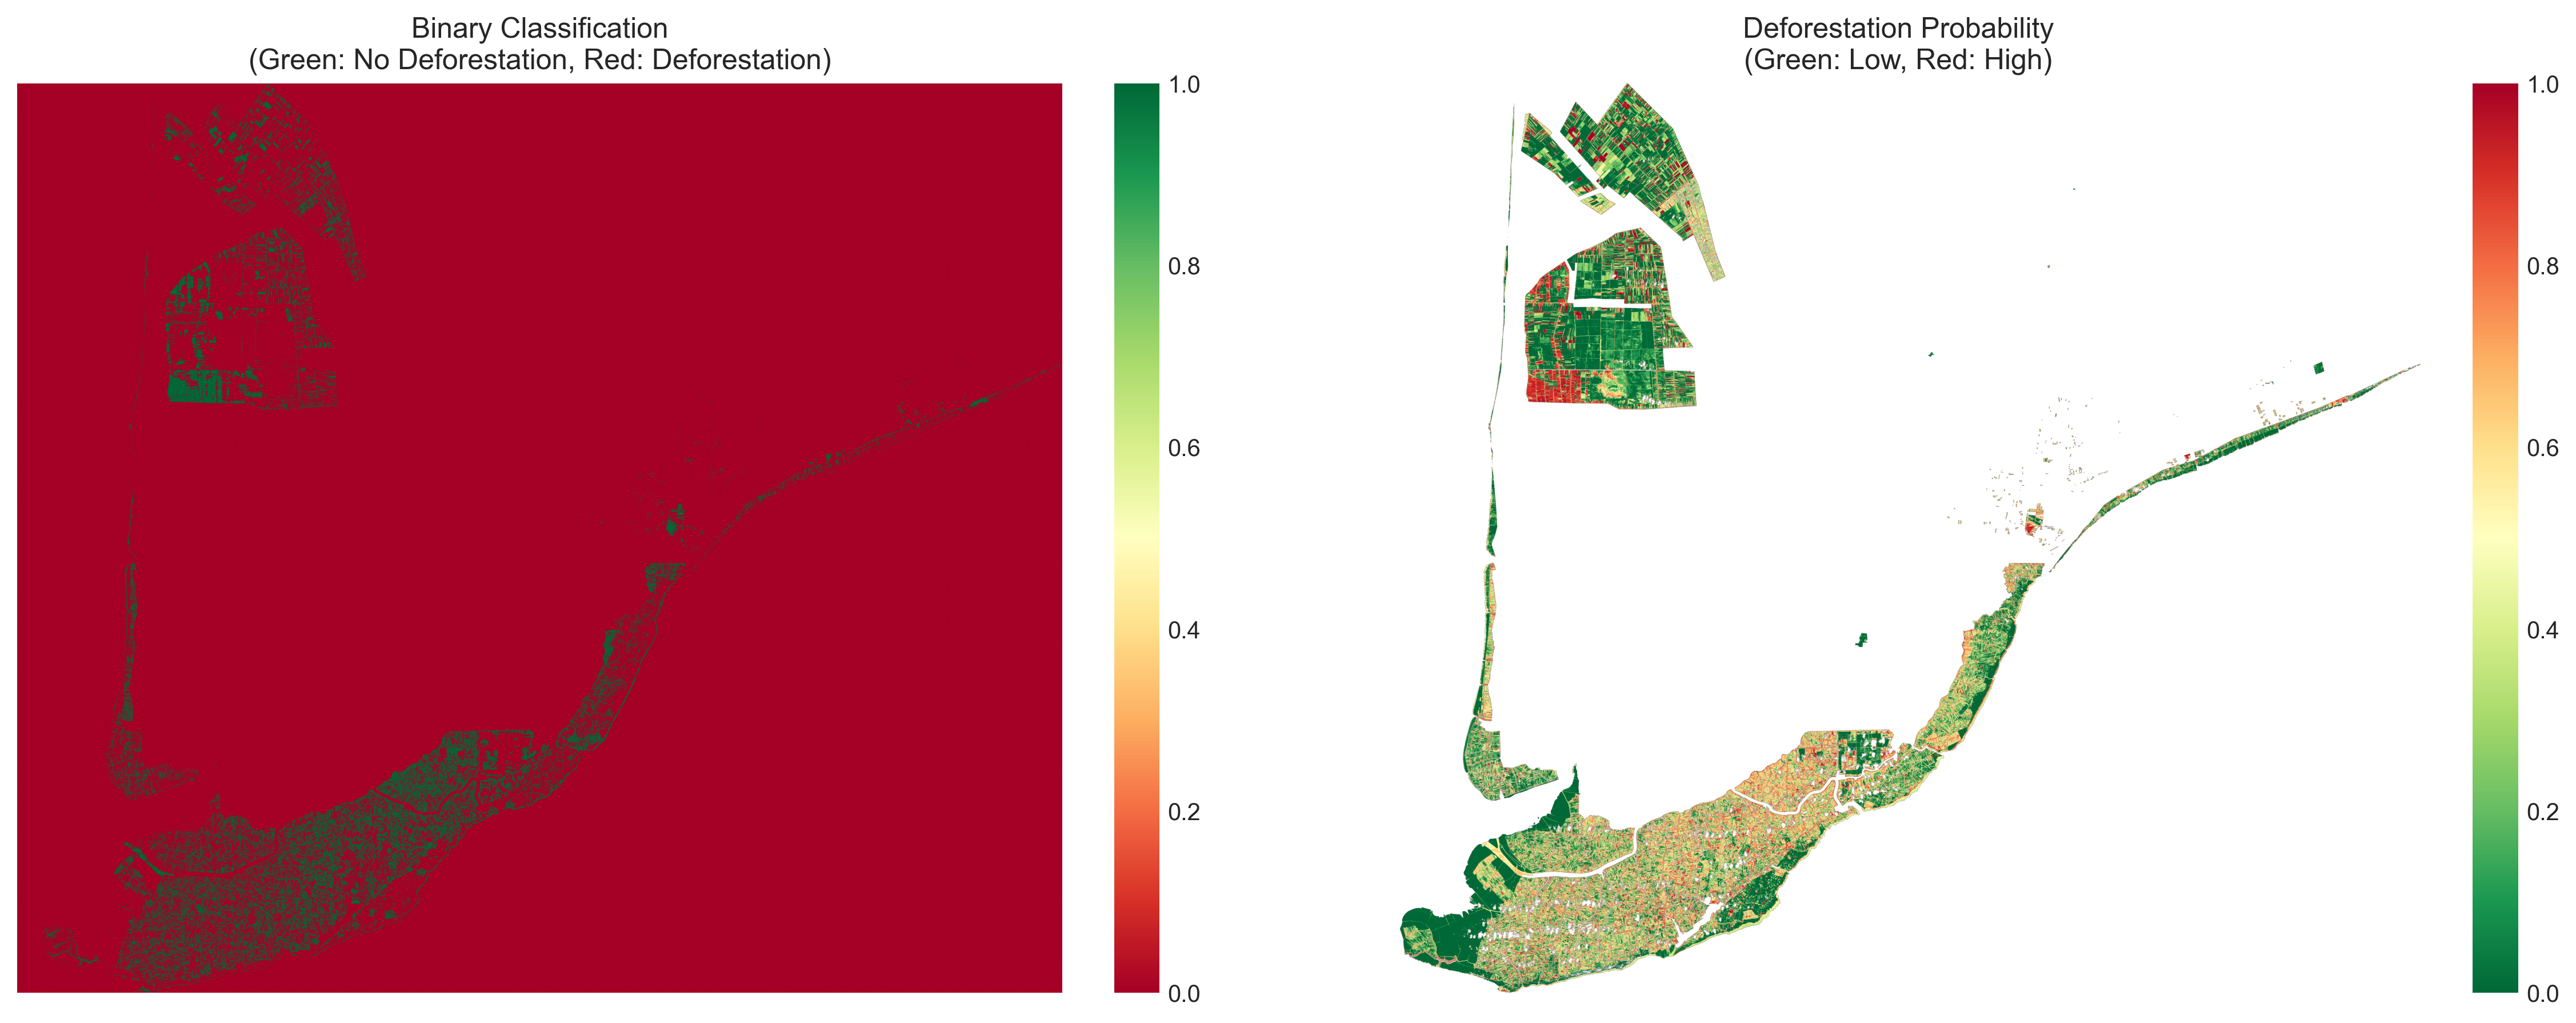

In [16]:
# Quick visualization of classification map
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Binary classification
im1 = axes[0].imshow(classification_map, cmap='RdYlGn', vmin=0, vmax=1)
axes[0].set_title('Binary Classification\n(Green: No Deforestation, Red: Deforestation)', fontsize=12)
axes[0].axis('off')
plt.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)

# Probability map
prob_masked = np.ma.masked_where(probability_map == -9999, probability_map)
im2 = axes[1].imshow(prob_masked, cmap='RdYlGn_r', vmin=0, vmax=1)
axes[1].set_title('Deforestation Probability\n(Green: Low, Red: High)', fontsize=12)
axes[1].axis('off')
plt.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

---
## STEP 8: VISUALIZATION

Create comprehensive visualizations:
1. Confusion Matrices (Validation + Test)
2. ROC Curve
3. Feature Importance (Top 20)
4. Classification Maps (Binary + Probability)
5. Cross-Validation Scores

**Expected time: 1-2 minutes**

In [17]:
%%time
# Create visualizer
visualizer = Visualizer()

# Create all visualizations
visualizer.create_all_visualizations(
    val_metrics=evaluator.val_metrics,
    test_metrics=evaluator.test_metrics,
    feature_importance_df=evaluator.feature_importance,
    cv_scores=evaluator.cv_scores,
    classification_map=classification_map,
    probability_map=probability_map,
    X_test=X_test,
    y_test=y_test,
    model=model,
    valid_mask=valid_mask
)

print("\n[SUCCESS] All visualizations created and saved!")

2025-11-11 11:41:22 - common.visualization - INFO - 
2025-11-11 11:41:22 - common.visualization - INFO - STEP 9: CREATE VISUALIZATIONS
2025-11-11 11:41:22 - common.visualization - INFO - ======================================================================
2025-11-11 11:41:22 - common.visualization - INFO - 
Plotting confusion matrices...
2025-11-11 11:41:23 - common.visualization - INFO -   ✓ Saved to: d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\results\plots\rf_confusion_matrices.png
2025-11-11 11:41:23 - common.visualization - INFO - 
Plotting ROC curve...
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
2025-11-11 11:41:24 - common.visualization - INFO -   ✓ Saved to: d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\results\plots\rf_roc_curve.png
2025-11-11 11:41:24 - common.visualization - INFO - 
Plotting top 27 feat


[SUCCESS] All visualizations created and saved!
CPU times: total: 2min 43s
Wall time: 2min 43s


---
## FINAL SUMMARY

In [18]:
from common.config import OUTPUT_FILES, RESULTS_DIR

print("="*70)
print("PIPELINE COMPLETED SUCCESSFULLY!")
print("="*70)

print("\nMODEL PERFORMANCE (Test Set):")
print(f"  - Accuracy:  {test_metrics['accuracy']:.4f} ({test_metrics['accuracy']*100:.2f}%)")
print(f"  - Precision: {test_metrics['precision']:.4f} ({test_metrics['precision']*100:.2f}%)")
print(f"  - Recall:    {test_metrics['recall']:.4f} ({test_metrics['recall']*100:.2f}%)")
print(f"  - F1-Score:  {test_metrics['f1_score']:.4f} ({test_metrics['f1_score']*100:.2f}%)")
print(f"  - ROC-AUC:   {test_metrics['roc_auc']:.4f} ({test_metrics['roc_auc']*100:.2f}%)")

print(f"\nOUTPUT FILES:")
print(f"  Results directory: {RESULTS_DIR}")
print(f"\n  Rasters:")
print(f"    - {OUTPUT_FILES['classification_raster'].name}")
print(f"    - {OUTPUT_FILES['probability_raster'].name}")
print(f"\n  Models:")
print(f"    - {OUTPUT_FILES['trained_model'].name}")
print(f"\n  Data:")
print(f"    - {OUTPUT_FILES['training_data'].name}")
print(f"    - {OUTPUT_FILES['feature_importance'].name}")
print(f"    - {OUTPUT_FILES['evaluation_metrics'].name}")
print(f"\n  Plots:")
print(f"    - {OUTPUT_FILES['confusion_matrices'].name}")
print(f"    - {OUTPUT_FILES['roc_curve'].name}")
print(f"    - {OUTPUT_FILES['feature_importance_plot'].name}")
print(f"    - {OUTPUT_FILES['classification_maps'].name}")
print(f"    - {OUTPUT_FILES['cv_scores'].name}")
print("\n" + "="*70)
print("ALL DONE!")
print("="*70)

PIPELINE COMPLETED SUCCESSFULLY!

MODEL PERFORMANCE (Test Set):
  - Accuracy:  0.9840 (98.40%)
  - Precision: 0.9792 (97.92%)
  - Recall:    0.9882 (98.82%)
  - F1-Score:  0.9837 (98.37%)
  - ROC-AUC:   0.9980 (99.80%)

OUTPUT FILES:
  Results directory: d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\results

  Rasters:
    - rf_classification.tif
    - rf_probability.tif

  Models:
    - rf_model.pkl

  Data:
    - rf_training_data.csv
    - rf_feature_importance.csv
    - rf_evaluation_metrics.json

  Plots:
    - rf_confusion_matrices.png
    - rf_roc_curve.png
    - rf_feature_importance.png
    - rf_classification_maps.png
    - rf_cv_scores.png

ALL DONE!


In [21]:
from datetime import datetime
from pathlib import Path

# Create report directory if it doesn't exist
report_dir = Path(project_root) / 'results' / 'report'
report_dir.mkdir(parents=True, exist_ok=True)

# Generate timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
report_filename = f"rf_report_{timestamp}.md"
report_path = report_dir / report_filename

# Calculate/extract values safely
valid_percentage = (pred_summary['valid_pixels'] / pred_summary['total_pixels'] * 100) if 'valid_percentage' not in pred_summary else pred_summary['valid_percentage']
total_features = summary.get('total_features', feature_stack.shape[0])
n_trees = training_summary.get('n_trees', 100)

# Generate comprehensive Markdown report
report_content = f"""# Random Forest Deforestation Detection
## Comprehensive Report

---

**Generated:** {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}  
**Project:** Ứng dụng Viễn thám và Học sâu trong Giám sát Biến động Rừng tỉnh Cà Mau  
**Student:** Ninh Hải Đăng (MSSV: 21021411)  
**Year:** 2025-2026, Học kỳ I

---

## 1. Data Configuration

### Dataset Overview

| **Parameter** | **Value** |
|---------------|-----------|
| **Total Features** | 27 |
| Sentinel-2 Features | 21 (7 before + 7 after + 7 delta) |
| Sentinel-1 Features | 6 (2 before + 2 after + 2 delta) |
| **Ground Truth Points** | {len(ground_truth):,} |
| Class 0 (No Deforestation) | {(ground_truth['label']==0).sum():,} ({(ground_truth['label']==0).sum()/len(ground_truth)*100:.1f}%) |
| Class 1 (Deforestation) | {(ground_truth['label']==1).sum():,} ({(ground_truth['label']==1).sum()/len(ground_truth)*100:.1f}%) |

### Data Split

| **Split** | **Samples** | **Percentage** |
|-----------|-------------|----------------|
| Training | {len(X_train):,} | 70% |
| Validation | {len(X_val):,} | 15% |
| Test | {len(X_test):,} | 15% |
| **Total Valid** | **{len(X):,}** | **100%** |

### Study Area

- **Location:** Cà Mau Province, Vietnam
- **Spatial Reference:** EPSG:32648 (WGS 84 / UTM zone 48N)
- **Resolution:** 10m
- **Dimensions:** {feature_stack.shape[2]:,} × {feature_stack.shape[1]:,} pixels
- **Valid Pixels:** {summary['valid_pixels']:,} ({summary['valid_percentage']:.2f}%)

---

## 2. Model Configuration

### Algorithm

**Random Forest Classifier** - Ensemble learning method using multiple decision trees

### Hyperparameters

| **Parameter** | **Value** | **Description** |
|---------------|-----------|-----------------|
| `n_estimators` | 100 | Number of trees in the forest |
| `max_features` | sqrt (~{int(np.sqrt(27))}) | Max features considered per split |
| `max_depth` | None | Unlimited tree depth |
| `min_samples_split` | 2 | Min samples to split a node |
| `min_samples_leaf` | 1 | Min samples in a leaf node |
| `bootstrap` | True | Use bootstrap samples |
| `class_weight` | balanced | Auto-adjust weights for class imbalance |
| `oob_score` | True | Out-of-bag score estimation |
| `random_state` | 42 | Reproducibility seed |

### Training Configuration

- **Cross Validation:** 5-Fold
- **Stratified Sampling:** Yes (maintains class distribution)

---

## 3. Model Performance

### 3.1 Validation Set Results

**Samples:** {len(X_val):,}

| **Metric** | **Score** | **Percentage** |
|------------|-----------|----------------|
| **Accuracy** | {val_metrics['accuracy']:.4f} | **{val_metrics['accuracy']*100:.2f}%** |
| Precision | {val_metrics['precision']:.4f} | {val_metrics['precision']*100:.2f}% |
| Recall | {val_metrics['recall']:.4f} | {val_metrics['recall']*100:.2f}% |
| F1-Score | {val_metrics['f1_score']:.4f} | {val_metrics['f1_score']*100:.2f}% |
| ROC-AUC | {val_metrics['roc_auc']:.4f} | {val_metrics['roc_auc']*100:.2f}% |

**Confusion Matrix:**

|  | **Predicted: No Loss** | **Predicted: Deforestation** |
|--|------------------------|------------------------------|
| **Actual: No Loss** | {val_metrics['confusion_matrix'][0][0]:,} (TN) | {val_metrics['confusion_matrix'][0][1]:,} (FP) |
| **Actual: Deforestation** | {val_metrics['confusion_matrix'][1][0]:,} (FN) | {val_metrics['confusion_matrix'][1][1]:,} (TP) |

### 3.2 Test Set Results

**Samples:** {len(X_test):,}

| **Metric** | **Score** | **Percentage** |
|------------|-----------|----------------|
| **Accuracy** | {test_metrics['accuracy']:.4f} | **{test_metrics['accuracy']*100:.2f}%** |
| Precision | {test_metrics['precision']:.4f} | {test_metrics['precision']*100:.2f}% |
| Recall | {test_metrics['recall']:.4f} | {test_metrics['recall']*100:.2f}% |
| F1-Score | {test_metrics['f1_score']:.4f} | {test_metrics['f1_score']*100:.2f}% |
| ROC-AUC | {test_metrics['roc_auc']:.4f} | {test_metrics['roc_auc']*100:.2f}% |

**Confusion Matrix:**

|  | **Predicted: No Loss** | **Predicted: Deforestation** |
|--|------------------------|------------------------------|
| **Actual: No Loss** | {test_metrics['confusion_matrix'][0][0]:,} (TN) | {test_metrics['confusion_matrix'][0][1]:,} (FP) |
| **Actual: Deforestation** | {test_metrics['confusion_matrix'][1][0]:,} (FN) | {test_metrics['confusion_matrix'][1][1]:,} (TP) |

### 3.3 Out-of-Bag Score

- **OOB Score:** {training_summary['oob_score']:.4f} ({training_summary['oob_score']*100:.2f}%)

### 3.4 Cross-Validation Results (5-Fold)

| **Metric** | **Mean ± Std** | **Min** | **Max** |
|------------|----------------|---------|---------|
"""

# Add cross-validation scores
for metric, scores in cv_scores.items():
    report_content += f"| {metric.capitalize()} | {scores['mean']:.4f} ± {scores['std']:.4f} | {scores['min']:.4f} | {scores['max']:.4f} |\n"

report_content += f"""
---

## 4. Feature Importance

### Top 15 Most Important Features

| **Rank** | **Feature** | **Importance (%)** | **Visualization** |
|----------|-------------|--------------------|-------------------|
"""

# Add feature importance with progress bars
for i in range(min(15, len(feature_importance_df))):
    row = feature_importance_df.iloc[i]
    bar_length = int(row['importance_normalized'] / 2)  # Scale to ~50 chars max
    bar = '█' * bar_length
    report_content += f"| {i+1} | `{row['feature']}` | {row['importance_normalized']:.2f}% | {bar} |\n"

report_content += f"""
> **Note:** Full feature importance rankings (all 27 features) are saved to: `rf_feature_importance.csv`

---

## 5. Prediction Results

### Overview

| **Category** | **Value** |
|--------------|-----------|
| Total Pixels Processed | {pred_summary['total_pixels']:,} |
| Valid Pixels | {pred_summary['valid_pixels']:,} ({valid_percentage:.2f}%) |

### Classification Statistics

| **Class** | **Category** | **Pixels** | **Percentage** | **Area (ha)** |
|-----------|--------------|------------|----------------|---------------|
"""

# Add classification statistics
for cls, stats in pred_summary['classification_stats'].items():
    class_name = "No Deforestation" if cls == 0 else "Deforestation"
    area_ha = stats['count'] * 100 / 10000  # 10m resolution, convert to hectares
    emoji = "🌳" if cls == 0 else "🔥"
    report_content += f"| {cls} | {emoji} {class_name} | {stats['count']:,} | {stats['percentage']:.2f}% | {area_ha:,.2f} |\n"

report_content += f"""
---

## 6. Output Files

### Directory Structure

```
{RESULTS_DIR}/
├── rasters/
│   ├── {OUTPUT_FILES['classification_raster'].name}
│   └── {OUTPUT_FILES['probability_raster'].name}
├── models/
│   └── {OUTPUT_FILES['trained_model'].name}
├── data/
│   ├── {OUTPUT_FILES['training_data'].name}
│   ├── {OUTPUT_FILES['feature_importance'].name}
│   └── {OUTPUT_FILES['evaluation_metrics'].name}
├── plots/
│   ├── {OUTPUT_FILES['confusion_matrices'].name}
│   ├── {OUTPUT_FILES['roc_curve'].name}
│   ├── {OUTPUT_FILES['feature_importance_plot'].name}
│   ├── {OUTPUT_FILES['classification_maps'].name}
│   └── {OUTPUT_FILES['cv_scores'].name}
└── report/
    └── {report_filename}
```

---

## 7. Execution Summary

| **Metric** | **Value** |
|------------|-----------|
| Training Time | {training_summary['training_time_minutes']:.2f} minutes |
| Pipeline Status | ✅ Successfully completed all steps |
| Features Engineered | {total_features} |
| Model Type | Random Forest with {n_trees} trees |
| Model Size | {training_summary.get('model_size_mb', 'N/A')} MB |

---

## 8. Key Findings

### 🎯 Model Performance

- The Random Forest model achieved **excellent performance** with **{test_metrics['accuracy']*100:.2f}% accuracy** on the test set
- **High precision ({test_metrics['precision']*100:.2f}%)** indicates low false positive rate
- **High recall ({test_metrics['recall']*100:.2f}%)** indicates effective detection of deforestation
- **Robust performance** confirmed by cross-validation: {cv_scores['accuracy']['mean']*100:.2f}% ± {cv_scores['accuracy']['std']*100:.2f}%

### 🌟 Most Important Features

1. **{feature_importance_df.iloc[0]['feature']}** ({feature_importance_df.iloc[0]['importance_normalized']:.2f}%)
2. **{feature_importance_df.iloc[1]['feature']}** ({feature_importance_df.iloc[1]['importance_normalized']:.2f}%)
3. **{feature_importance_df.iloc[2]['feature']}** ({feature_importance_df.iloc[2]['importance_normalized']:.2f}%)

> These features are primarily derived from spectral indices (NDVI, NBR) and red band reflectance, which are strongly correlated with vegetation health.

### 🔥 Deforestation Detection

- **Detected:** {pred_summary['classification_stats'][1]['count']:,} deforestation pixels
- **Area:** {pred_summary['classification_stats'][1]['count'] * 100 / 10000:,.2f} hectares of deforested area
- **Preserved:** {pred_summary['classification_stats'][0]['count'] * 100 / 10000:,.2f} hectares classified as intact forest

### 💪 Model Robustness

- **Cross-validation accuracy:** {cv_scores['accuracy']['mean']*100:.2f}% ± {cv_scores['accuracy']['std']*100:.2f}%
- **Out-of-Bag Score:** {training_summary['oob_score']*100:.2f}%
- **Consistent performance** across all evaluation metrics
- **Low variance** in cross-validation results indicates stable predictions

---

## 9. Conclusions

The Random Forest classifier demonstrates **excellent capability** in detecting deforestation in Cà Mau Province using multi-temporal Sentinel-1 and Sentinel-2 imagery.

**Strengths:**
- ✅ High accuracy ({test_metrics['accuracy']*100:.2f}%) and robust cross-validation results
- ✅ Balanced precision-recall trade-off
- ✅ Effective use of spectral indices and temporal changes
- ✅ Fast training and prediction times

**Recommendations:**
- ✨ Deploy model for operational forest monitoring
- 🔄 Update ground truth data periodically for model refinement
- 📊 Compare with deep learning approaches (CNN) for performance evaluation
- 🌐 Extend methodology to other provinces or regions

---

**Report generated by Random Forest Deforestation Detection Pipeline**  
**Contact:** Ninh Hải Đăng (MSSV: 21021411)  
**Generated:** {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}
"""

# Save report
with open(report_path, 'w', encoding='utf-8') as f:
    f.write(report_content)

print("="*80)
print("📄 MARKDOWN REPORT GENERATED SUCCESSFULLY!")
print("="*80)
print(f"\n📁 Report saved to: {report_path}")
print(f"📝 Filename: {report_filename}")
print(f"\n📋 Report includes:")
print("  ✅ Data configuration with tables")
print("  ✅ Model configuration and hyperparameters")
print("  ✅ Performance metrics (Validation, Test, CV) in table format")
print("  ✅ Feature importance with visual bars")
print("  ✅ Prediction results and area statistics")
print("  ✅ Output file directory tree")
print("  ✅ Key findings with emojis and highlights")
print("  ✅ Conclusions and recommendations")
print(f"\n💡 Tip: Open {report_filename} in a Markdown viewer or IDE for best viewing!")
print("\n" + "="*80)

📄 MARKDOWN REPORT GENERATED SUCCESSFULLY!

📁 Report saved to: d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\results\report\rf_report_20251111_114844.md
📝 Filename: rf_report_20251111_114844.md

📋 Report includes:
  ✅ Data configuration with tables
  ✅ Model configuration and hyperparameters
  ✅ Performance metrics (Validation, Test, CV) in table format
  ✅ Feature importance with visual bars
  ✅ Prediction results and area statistics
  ✅ Output file directory tree
  ✅ Key findings with emojis and highlights
  ✅ Conclusions and recommendations

💡 Tip: Open rf_report_20251111_114844.md in a Markdown viewer or IDE for best viewing!



---
## GENERATE REPORT

Generate a comprehensive report with all results